In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

In [2]:
# Define paths to data files
base_path = "/kaggle/input/kuairec-content-based"
interactions_big_path = os.path.join(base_path, "big_matrix.csv")
interactions_small_path = os.path.join(base_path, "small_matrix.csv")
item_features_path = os.path.join(base_path, "item_categories.csv")

interactions_big_df = pd.read_csv(interactions_big_path)
interactions_small_df = pd.read_csv(interactions_small_path)
item_features_df = pd.read_csv(item_features_path)

print(f"Interactions shape: {interactions_big_df.shape}")
print(f"Interactions small shape: {interactions_small_df.shape}")
print(f"Item features shape: {item_features_df.shape}")

Interactions shape: (12530806, 8)
Interactions small shape: (4676570, 8)
Item features shape: (10728, 2)


In [3]:
interactions_big_df.drop(columns=["date", 'time'], inplace=True)
interactions_big_df.rename(columns={'user_id': 'userId', 'video_id': 'itemId'}, inplace=True)
interactions_small_df.drop(columns=["date", 'time'], inplace=True)
interactions_small_df.rename(columns={'user_id': 'userId', 'video_id': 'itemId'}, inplace=True)

item_features_df["feat"] = item_features_df["feat"].map(eval)
all_categories = [i for i in range(31)]

items_preproccesed = pd.DataFrame(index=item_features_df.index)

for category in sorted(all_categories):
    column_name = category
    items_preproccesed[column_name] = item_features_df['feat'].apply(lambda x: 1 if category in x else 0)
items_preproccesed['video_id'] = item_features_df["video_id"]
items_preproccesed.drop(columns=[14, 23, 27, 21, 0, 30, 22, 24, 29], inplace=True)
items_preproccesed.rename(columns={'video_id':'itemId'}, inplace=True)

#items_preproccesed.set_index('itemId', inplace=True)

In [4]:
items_preproccesed.set_index('itemId', inplace=True)

In [5]:
train_data = pd.merge(interactions_big_df, items_preproccesed, on='itemId', how='left')
test_data = pd.merge(interactions_small_df, items_preproccesed, on='itemId', how='left')

In [32]:
train_data[train_data['watch_ratio'] > 5] = 5
test_data[test_data['watch_ratio'] > 5] = 5

In [33]:
class ContentBasedRecommender:
    def __init__(self, item_features_df, params=None):
        self.item_features_df = item_features_df
        self.model = None
        self.user_profiles = {}
        
        # Default XGBoost parameters
        self.params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'eta': 0.1,
            'max_depth': 8,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'min_child_weight': 1
        }
        
        if params:
            self.params.update(params)
            
    def fit(self, train_data, feature_cols=None):
        """Train an XGBoost model for content-based recommendations."""
        
        if feature_cols is None:
            feature_cols = train_data.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
            feature_cols = [col for col in feature_cols if col not in ['userId', 'itemId', 'watch_ratio']]
        
        print(f"Using features: {feature_cols}")
        
        print("Training XGBoost model...")
        X = train_data[feature_cols].values
        y = train_data['watch_ratio'].values
        
        # Create user-specific indices to enable personalized training
        train_data['user_idx'] = train_data['userId'].astype('category').cat.codes
        
        # Create DMatrix for XGBoost
        dtrain = xgb.DMatrix(X, label=y)
        dtrain.set_group(train_data.groupby('user_idx').size().values)
        
        # Add early stopping with a validation set
        X_train, X_val = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
        y_train, y_val = y[:int(0.8*len(y))], y[int(0.8*len(y)):]
        
        dtrain_final = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        # Train with early stopping
        self.model = xgb.train(
            self.params, 
            dtrain_final, 
            num_boost_round=100,
            evals=[(dval, 'validation')],
            early_stopping_rounds=20,
            verbose_eval=10
        )
        
        print("Creating user profiles...")
        # Create user profiles (average features of items each user has interacted with)
        for user_id, group in train_data.groupby('userId'):
            self.user_profiles[user_id] = group[feature_cols].mean().values
            
        return self
    def evaluate(self, test_data, feature_cols=None):
        """
        Evaluate the model using RMSE and MAE metrics.
        
        Parameters:
        -----------
        test_data : pandas.DataFrame
            Test data containing actual watch_ratio values
        feature_cols : list, optional
            Feature columns to use for prediction
            
        Returns:
        --------
        dict
            Dictionary with RMSE and MAE metrics
        """
        if feature_cols is None:
            feature_cols = self.item_features_df.columns.tolist()
            feature_cols = [col for col in feature_cols if col not in ['userId', 'itemId', 'watch_ratio']]
        
        print("Generating predictions for evaluation...")
        X_test = test_data[feature_cols].values
        y_true = test_data['watch_ratio'].values
        
        # Create DMatrix for prediction
        dtest = xgb.DMatrix(X_test)
        
        # Generate predictions
        y_pred = self.model.predict(dtest)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = np.mean(np.abs(y_true - y_pred))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_true, y_pred, alpha=0.3)
        plt.plot([0, 5], [0, 5], 'r--')
        plt.xlabel('Actual Watch Ratio')
        plt.ylabel('Predicted Watch Ratio')
        plt.title('Actual vs Predicted Watch Ratio')

        # Set x and y axis limits to be between 1 and 5
        plt.xlim(0, 5)
        plt.ylim(0, 5)

        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()
        
        return {
            "rmse": rmse,
            "mae": mae
        }

In [17]:
train_data.drop(columns=['timestamp'], inplace=True)
#train_data.columns

In [34]:
# Initialize and train the recommender
recommender = ContentBasedRecommender(item_features_df)
recommender.fit(train_data, feature_cols=items_preproccesed.columns.tolist())

Using features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 25, 26, 28]
Training XGBoost model...
[0]	validation-rmse:0.79967
[10]	validation-rmse:0.71626
[20]	validation-rmse:0.70422
[30]	validation-rmse:0.70217
[40]	validation-rmse:0.70150
[50]	validation-rmse:0.70122
[60]	validation-rmse:0.70099
[70]	validation-rmse:0.70085
[80]	validation-rmse:0.70079
[90]	validation-rmse:0.70072
[99]	validation-rmse:0.70068
Creating user profiles...


Generating predictions for evaluation...
RMSE: 0.5750
MAE: 0.4076


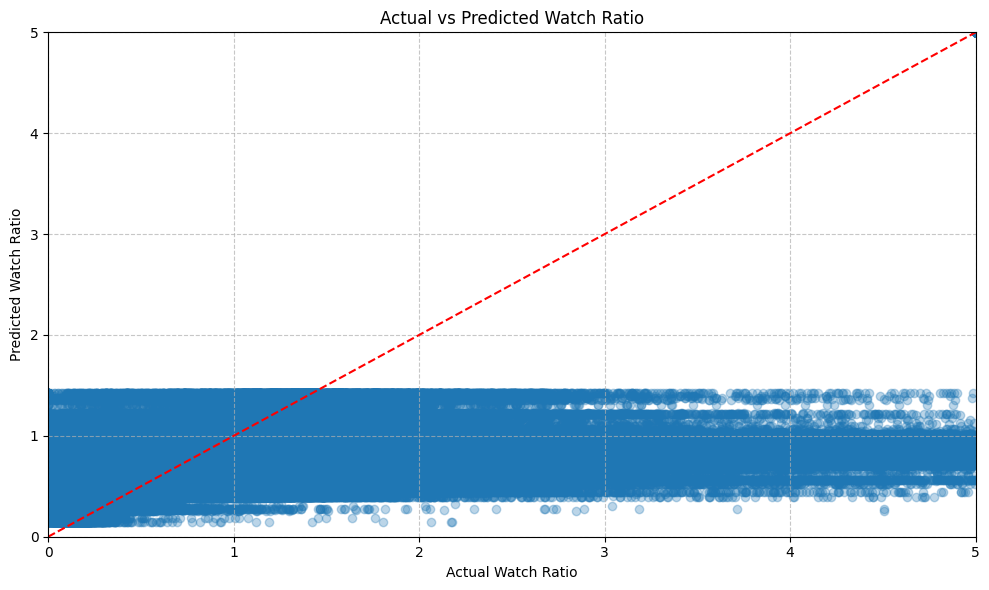

Test RMSE: 0.5750
Test MAE: 0.4076


In [35]:
# Evaluate the model on test data
metrics = recommender.evaluate(test_data, feature_cols=items_preproccesed.columns.tolist())
print(f"Test RMSE: {metrics['rmse']:.4f}")
print(f"Test MAE: {metrics['mae']:.4f}")

<Figure size 1200x600 with 0 Axes>

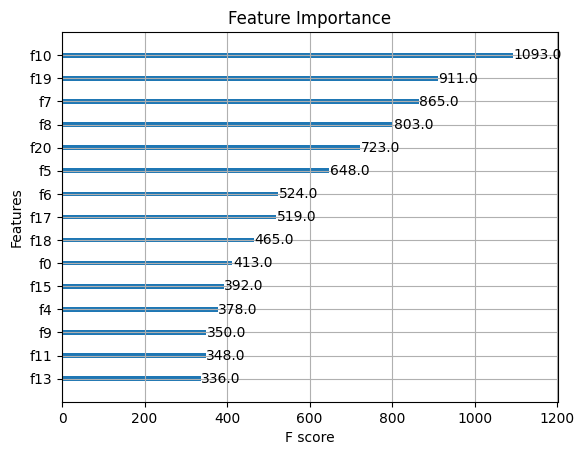

In [19]:
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(recommender.model, max_num_features=15)
plt.title('Feature Importance')
plt.show()

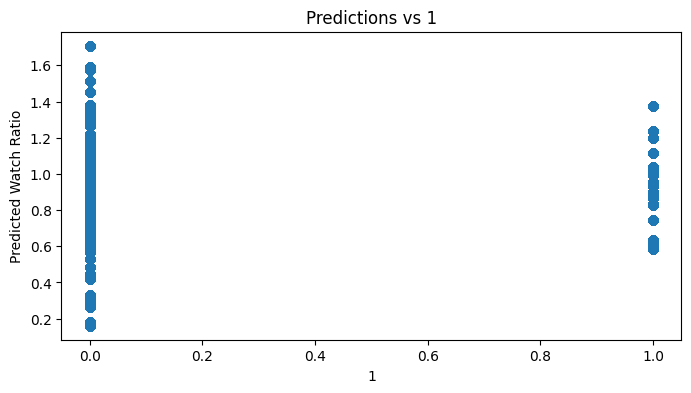

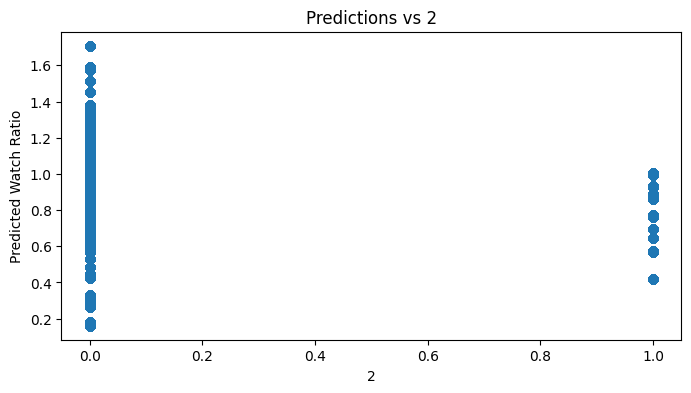

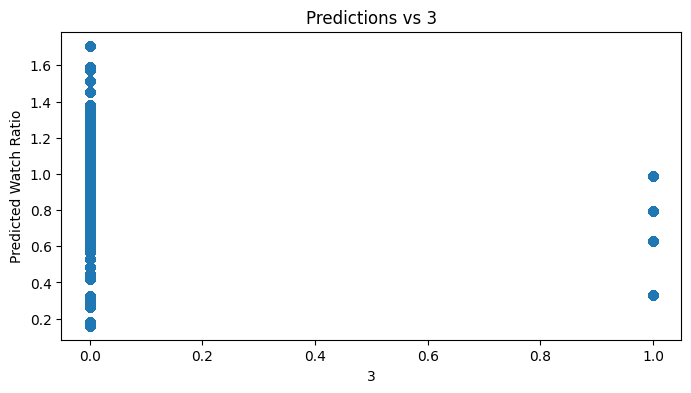

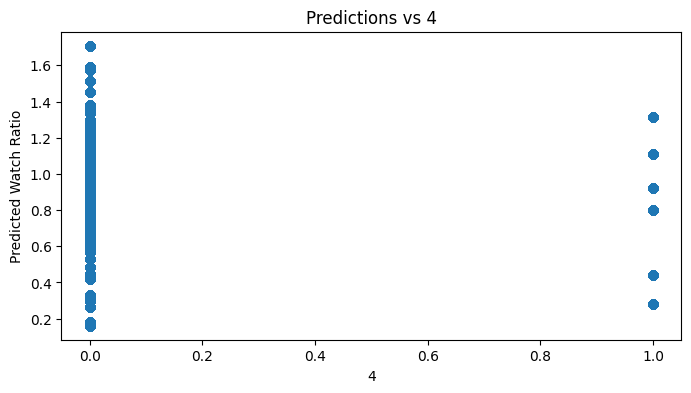

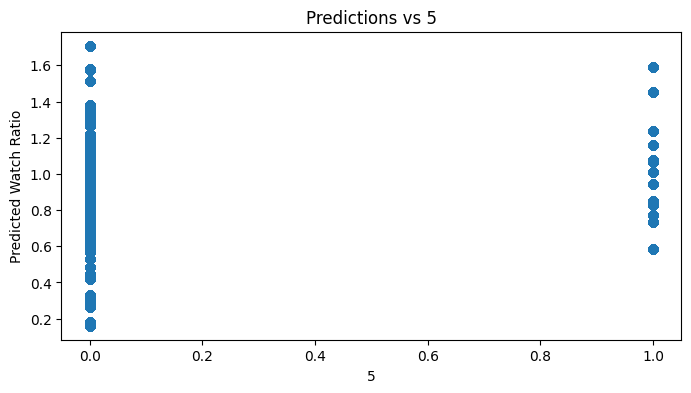

In [ ]:
dtest = xgb.DMatrix(test_data[items_preproccesed.columns].values)
test_data['predictions'] = recommender.model.predict(dtest)

# Examine how predictions vary with different feature values
for feature in items_preproccesed.columns[:5]:
    plt.figure(figsize=(8, 4))
    plt.scatter(test_data[feature], test_data['predictions'], alpha=0.3)
    plt.title(f'Predictions vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Predicted Watch Ratio')
    plt.show()

In [24]:
test_data['predictions']

0          1.138834
1          1.113246
2          0.863500
3          0.952485
4          0.780877
             ...   
4676565    0.952485
4676566    0.993477
4676567    0.582425
4676568    0.863500
4676569    0.634930
Name: predictions, Length: 4676570, dtype: float32